In [1]:
!pip install llama-index-vector-stores-lancedb
!pip install llama_index
%pip install lancedb==0.6.13 
!pip install moviepy
!pip install pydub
!pip install pytube
!pip install SpeechRecognition
!pip install ffmpeg-python
!pip install ftfy regex tqdm
!pip install yt-dlp
!pip install -U openai-whisper
!pip install llama-index-embeddings-clip
!pip install git+https://github.com/openai/CLIP.git
!pip install torch torchvision
!pip install llama-index-embeddings-huggingface
!pip install llama-index-multi-modal-llms-gemini

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.2/32.2 MB 55.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 43.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 84.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 49.4 MB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.9.1 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.0/241.0 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.5/455.5 kB 28.6 MB/s eta 0:00:00
  Attempting

In [2]:
!pip install llama-index-vector-stores-lancedb

  Using cached lancedb-0.18.0-cp39-abi3-manylinux_2_28_x86_64.whl.metadata (4.0 kB)
  Using cached pylance-0.22.0-cp39-abi3-manylinux_2_28_x86_64.whl.metadata (7.2 kB)
Using cached lancedb-0.18.0-cp39-abi3-manylinux_2_28_x86_64.whl (32.2 MB)
Using cached pylance-0.22.0-cp39-abi3-manylinux_2_28_x86_64.whl (38.3 MB)
  Attempting uninstall: pylance
    Found existing installation: pylance 0.10.12
    Uninstalling pylance-0.10.12:
      Successfully uninstalled pylance-0.10.12
  Attempting uninstall: lancedb
    Found existing installation: lancedb 0.6.13
    Uninstalling lancedb-0.6.13:
      Successfully uninstalled lancedb-0.6.13


## Importing libraries

In [3]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("gemini_api")

In [4]:
from moviepy.editor import VideoFileClip
from pathlib import Path
import speech_recognition as sr
from pprint import pprint
from PIL import Image
import matplotlib.pyplot as plt
import yt_dlp

In [5]:
import os
print(os.getcwd())

/kaggle/working


## We define the url for the video and then create our output folders

In [6]:
video_url = "https://youtu.be/E0Hmnixke2g?si=xqYrPq5MtQ9qB0m4"
output_video_path = "/kaggle/working/video_data/"
output_folder = "/kaggle/working/mixed_data/" # this will for images and text
output_audio_path = "/kaggle/working/output_audio.wav" # this is for storing the audio where we'll extract the text.

## Now let's make a directory 'mixed_data

In [7]:
!mkdir mixed_data

## This's the path where the video will be stored

In [8]:
file_path = output_video_path + "input_vid.mp4.webm"

## This's function is for downloading video from youtube

In [9]:
def download_video(url, output_path, keep_original=False):
    # Configure yt-dlp options
    ydl_opts = {
        'outtmpl': f'{output_path}/input_vid.mp4',
    }
    
    # Add the `-k` option if `keep_original` is True
    if keep_original:
        ydl_opts['keepvideo'] = True

    # Download the video and extract metadata
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        info = ydl.extract_info(url, download=True)

    # Extract metadata
    metadata = {
        "Author": info.get('uploader'),
        "Title": info.get('title'),
        "Views": info.get('view_count'),
    }
    
    return metadata

## This generates images from the video

In [10]:
def video_to_image(video_path,output_folder):
    clip = VideoFileClip(video_path)
    clip.write_images_sequence(
        os.path.join(output_folder,"frame%04d.png"),fps = 0.2
    )
# Extracts frames at a rate of 0.2 frames per second (fps), which means one frame is extracted every 5 seconds (1 / 0.2 = 5 seconds).
# frame%04d.png means the images will be named frame0001.png, frame0002.png, and so on, where %04d ensures four digits with 
# leading zeros.

## This function generates audio from the video

In [11]:
def video_to_audio(video_path,output_audio_path):
    clip  = VideoFileClip(video_path)
    audio = clip.audio
    audio.write_audiofile(output_audio_path)

## Now we obtain text from the audio


In [12]:
def audio_to_text(audio_path):
    recognizer = sr.Recognizer()
    audio = sr.AudioFile(audio_path) # loading the audio file
    with audio as source: # opens the audio file as source
        audio_data = recognizer.record(source)# record the audio file and stores it in a variable
        try:
            text = recognizer.recognize_whisper(audio_data) # transcribe audio into text
        except sr.UnknownValueError: # Raised if the model is unable to understand the audio content
            print('Speech recognizer could not understand audio')

    return text

# The function processes an audio file, transcribes its content into text using the Whisper model (via recognize_whisper),
# and handles cases where the audio might be unintelligible.


## Calling the functions

In [13]:
metadata_vid = download_video(video_url,output_video_path,keep_original=True)

[youtube] Extracting URL: https://youtu.be/E0Hmnixke2g?si=xqYrPq5MtQ9qB0m4
[youtube] E0Hmnixke2g: Downloading webpage
[youtube] E0Hmnixke2g: Downloading tv player API JSON
[youtube] E0Hmnixke2g: Downloading ios player API JSON
[youtube] E0Hmnixke2g: Downloading player dd017f77
[youtube] E0Hmnixke2g: Downloading m3u8 information
[info] E0Hmnixke2g: Downloading 1 format(s): 616+251
[hlsnative] Downloading m3u8 manifest
[hlsnative] Total fragments: 171
[download] Destination: /kaggle/working/video_data//input_vid.mp4.f616.mp4
[download] 100% of   39.77MiB in 00:00:05 at 7.45MiB/s                    
[download] Destination: /kaggle/working/video_data//input_vid.mp4.f251.webm
[download] 100% of   14.47MiB in 00:00:00 at 42.76MiB/s    
[Merger] Merging formats into "/kaggle/working/video_data//input_vid.mp4.webm"


In [14]:
metadata_vid

{'Author': 'Infinite Codes',
 'Title': 'All Machine Learning algorithms explained in 17 min',
 'Views': 529996}

In [15]:
metadata_vid['Title']

'All Machine Learning algorithms explained in 17 min'

## We save our images to the 'mixed_data' folder

In [16]:
video_to_image(file_path,output_folder)

Moviepy - Writing frames /kaggle/working/mixed_data/frame%04d.png.


Moviepy - Done writing frames /kaggle/working/mixed_data/frame%04d.png.


In [17]:
video_to_audio(file_path,output_audio_path)

MoviePy - Writing audio in /kaggle/working/output_audio.wav


MoviePy - Done.


In [18]:
text_data = audio_to_text(output_audio_path)

100%|███████████████████████████████████████| 139M/139M [00:07<00:00, 19.4MiB/s]


In [19]:
text_data

" In the next 17 minutes, I will give you an overview of the most important machine learning algorithms to help you decide which one is right for your problem. My name is Tim and I have been a data scientist for over 10 years and taught all of these algorithms to hundreds of students in real-life machine learning boot camps. There is a simple strategy for picking the right algorithm for your problem. In 17 minutes, you will know how to pick the right one for any problem and get a basic intuition of each algorithm and how they relate to each other. My goal is to give as many of you as possible an intuitive understanding of the major machine learning algorithms. To make you stop feeling overwhelmed. According to Wikipedia, machine learning is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalize to unseen data and thus perform tasks without explicit instructions. Much of the recent advancemen

## We save our text into a file inside the 'mixed_data' folder

In [20]:
with open(output_folder + "output_text.txt","w") as file:
    file.write(text_data)

print('Text data saved...')
file.close()

Text data saved...


In [21]:
from llama_index.core.indices import MultiModalVectorStoreIndex 
from llama_index.core import SimpleDirectoryReader, StorageContext
from llama_index.core import Settings
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.vector_stores.lancedb import LanceDBVectorStore

*A VectorStore is a specialized database or storage system used to manage and retrieve vector embeddings, often for similarity search tasks (e.g., semantic search, nearest-neighbor search, etc.).*

**text_store:** *A vector store instance dedicated to storing text embeddings.*

**uri='lancedb':** *Specifies the database location. 'lancedb' could represent a local or remote LanceDB instance.*

**table_name='text_collection':** *Indicates the table name in the database where text-related vectors will be stored.*

In [22]:
text_store = LanceDBVectorStore(uri = 'lancedb', table_name = 'text_collection')
img_store = LanceDBVectorStore(uri = 'lancedb', table_name = 'image_collection')

### The StorageContext likely acts as a unified interface or abstraction layer to manage multiple data stores (like text and image vector stores).
### It enables seamless interaction with the underlying vector stores (text and image) for storage, retrieval, and query operations.

In [23]:
storage_context = StorageContext.from_defaults(vector_store = text_store,image_store = img_store)

### Loading the documents i.e Images and text

In [24]:
documents = SimpleDirectoryReader(output_folder).load_data()

### This code creates a MultiModalVectorStoreIndex, which is a data structure for indexing and searching embeddings across multiple modalities (e.g., text and images)

In [25]:
embed_model = HuggingFaceEmbedding(
    model_name="BAAI/bge-small-en-v1.5"
) # for creating vector representations of the documents
index = MultiModalVectorStoreIndex.from_documents(documents,storage_context = storage_context,embed_model=embed_model)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

100%|███████████████████████████████████████| 338M/338M [00:15<00:00, 23.4MiB/s]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

## creating the retriever


In [26]:
retriever_engine = index.as_retriever(
    similarity_top_k=3, image_similarity_top_k=3
)

## Defining our prompt

In [35]:
qa_tmpl_str = (
    "Based on the provided information, including relevant images and retrieved context from the video, \
    accurately and precisely answer the query without any additional prior knowledge.\n"
    "---------------------\n"
    "Context: {context_str}\n"
    "Metadata for video: {metadata_str} \n"
    "---------------------\n"
    "Query: {query_str}\n"
    "Answer: "
)

In [45]:
from llama_index.core.response.notebook_utils import display_source_node #to visually display a source node in a notebook  
 # (e.g., Jupyter or Colab).
from llama_index.core.schema import ImageNode # to store, retrieve, and process images as part of your index.

### This function, retrieve, is designed to query a retriever engine and separate the results into two categories: retrieved images and retrieved text

In [49]:
def retrieve(retriever_engine,query_str):
    retrieval_results = retriever_engine.retrieve(query_str)
    retrieved_image = list()
    retrieved_text = list()
# Contains a node attribute, which is either an ImageNode or a text node.
    for res_node in retrieval_results:
        if isinstance(res_node.node,ImageNode):
            retrieved_image.append(res_node.node.metadata['file_path'])
        else:
            display_source_node(res_node,source_length = 200)
            retrieved_text.append(res_node.text)

    return retrieved_image,retrieved_text

In [51]:
query = "What is a Support Vector Machine?"

In [55]:
img,text = retrieve(retriever_engine,query)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

**Node ID:** da7de10f-d02c-48ad-9b0d-3462b1c2c727<br>**Similarity:** 0.7522479891777039<br>**Text:** Support vector machine is a supervised machine learning algorithm originally designed for classification tasks, but it can also be used for regression tasks. The core concept of the algorithm is to...<br>

**Node ID:** 49295268-bd8f-4fff-8e9e-80e198731d94<br>**Similarity:** 0.6311336755752563<br>**Text:** In the next 17 minutes, I will give you an overview of the most important machine learning algorithms to help you decide which one is right for your problem. My name is Tim and I have been a data s...<br>

**Node ID:** 2a32761e-8640-40d8-98d3-7118f2b3bcde<br>**Similarity:** 0.5365191102027893<br>**Text:** What if we now had even more layers? This is called deep learning and can result in very complex hidden features, so that might represent all kinds of complex information in the pictures, like the ...<br>

## Plotting the retrieved images

In [59]:
import matplotlib.pyplot as plt
def plot_image(images_path):
    images_shown = 0
    plt.figure(figsize=(15,9))
    for path in images_path:
        if os.path.isfile(path):
            image = Image.open(path)
            plt.subplot(2,3,images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 5:
                break
        

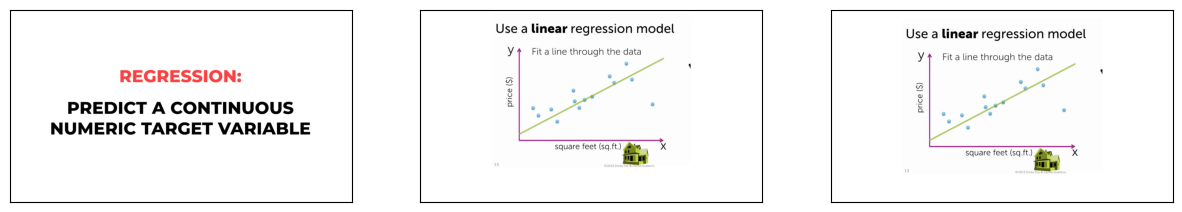

In [60]:
plot_image(img)

## let's now define our LMM

In [29]:
from llama_index.multi_modal_llms.gemini import GeminiMultiModal

In [30]:
lmm = GeminiMultiModal(model = "models/gemini-1.5-pro",api_key = secret_value_0 )

In [33]:
query_str = 'Define machine learning?'

In [38]:
context_str = "".join(text_data)

In [39]:
import json
metadata_str = json.dumps(metadata_vid)

In [61]:
image_documents = SimpleDirectoryReader(input_files = img).load_data()

In [62]:
results = lmm.complete(
    prompt = qa_tmpl_str.format(
        query_str = query_str,metadata_str = metadata_str,context_str = context_str
    ),
    image_documents = image_documents
)

## A sample user input

In [63]:
pprint(results.text)

('According to Wikipedia, machine learning is a field of study in artificial '
 'intelligence concerned with the development and study of statistical '
 'algorithms that can learn from data and generalize to unseen data and thus '
 'perform tasks without explicit instructions.  Much of the recent '
 'advancements in AI are driven by neural networks.\n')
